# Sistema RAG con Contextual AI
```{index} RAG
```
NOTA 1: Este documento es una traducción de otro localizado en esta dirección:

https://github.com/NirDiamant/agents-towards-production/blob/main/tutorials/agent-RAG-with-Contextual/contextual_tutorial.ipynb

Y el lugar de almacenamiento al que se hace referencia aquí, lo puedes localizar también en esta dirección:

https://app.contextual.ai/?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook

NOTA 2: Este sistema es de pago, aunque cuando te das de alta tienes un crédito gratuito que te permite hacer pruebas y ver su comportamiento

El plan de pagos de Contextual AI se basa principalmente en un modelo de pago por uso (on-demand) sin compromisos mínimos, con créditos gratuitos iniciales y opciones escalables para empresas. Los precios varían según el componente utilizado, como consultas, APIs modulares o ingesta de datos, y están calculados por tokens, páginas o consultas procesadas.

**Modos de Pago**
Contextual AI ofrece dos modos principales de uso: On-Demand, que es pay-as-you-go con $25 en créditos gratuitos para nuevos workspaces, ideal para experimentación y escalabilidad flexible sin SLAs ni garantías de QPS; y Provisioned Throughput, que requiere contactar ventas para capacidades reservadas y acuerdos de nivel de servicio, enfocado en volúmenes de producción predecibles. Además, se pueden adquirir servicios de soporte experto por términos fijos, gestionados por el equipo de ventas o account managers.

**Precios On-Demand**

En modo On-Demand, los créditos se compran por adelantado y se descuentan según el uso; no hay mínimos ni compromisos, y se puede migrar a Provisioned Throughput según necesidades. La consulta (/query) para interactuar con un Agente invoca una pipeline RAG multistep con costo promedio de 0.05 por consulta, desglosado en: optimización de query (1/1M tokens), encode (0.03/1M tokens), rerank (0.12/1M tokens), filtro (1/1M tokens), generación (input 3/1M tokens, output 15/1M tokens) y chequeos de groundedness (1/1M tokens). Para ingesta de documentos en Datastores, el costo es de $48.50 por 1,000 páginas, cubriendo parseo, chunking e indexación en vector stores.

**APIs de Componentes**

Las APIs de componentes permiten flexibilidad para arquitecturas RAG existentes, con precios por uso: Parse (básico texto: 3/1,000 páginas; estándar multimodal: 40/1,000 páginas); Rerank (v2: 0.05/1M tokens, v2-mini: 0.02/1M tokens, o 0.12/1M tokens en algunos contextos); Generate (input: 3/1M tokens, output: 15/1M tokens); y LMUnit (input: $3/1M tokens para evaluaciones). Estos precios están sujetos a cambios, con la información actualizada a julio 2025.

Para una información actualizada se puede consultar la siguiente página web:

https://contextual.ai/pricing

## Introducción.

La creación de sistemas de generación aumentada por recuperación (RAG, Retrieval-Augmented Generation en inglés) para aplicaciones empresariales puede ser compleja, ya que implica estrategias de infraestructura, fragmentación y recuperación. Este tutorial muestra cómo utilizar la plataforma *Contextual AI's* para simplificar el proceso de creación de agentes RAG, lo que le permite centrarse en su caso de uso en lugar de en detalles de bajo nivel.

## Por qué es importante.

Las implementaciones tradicionales de RAG se enfrentan a numerosos retos:

* **Infraestructura compleja**: configuración de bases de datos vectoriales, modelos integrados y sistemas de recuperación.
  
* **Procesamiento de documentos**: gestión de diversos formatos, tablas, gráficos y contenido jerárquico.
Control de alucinaciones: garantizar que las respuestas se basen en los documentos originales.


* **Evaluación del rendimiento**: prueba y optimización de la precisión de la recuperación y la calidad de la respuesta.


La plataforma  *Contextual AI* ofrece un sistema gestionado diseñado para abordar estos retos y ayudarle a empezar a utilizar los agentes RAG rápidamente.

En este tutorial práctico, se creará un agente RAG completo para el análisis de documentos financieros y el razonamiento cuantitativo, con el fin de ver las cualidades de la plataforma *Contextual AI*.

Al final de este tutorial, se va a saber:

* Crear y configurar almacenes de datos para el almacenamiento y la indexación de documentos.
  
* Incorporar diversos tipos de documentos con un análisis preciso y consciente de la jerarquía.

  
* Crear e implemente agentes RAG con instrucciones y medidas de seguridad personalizadas.

  
* Realizar consultas e interacciones con sus agentes mediante lenguaje natural.

  
* Evaluar y optimizar el rendimiento de los agentes mediante marcos de pruebas automatizados.

## Configuración del entorno

En primer lugar, instalaremos las dependencias necesarias y configuraremos nuestro entorno de desarrollo. La biblioteca *contextual-client* proporciona enlaces Python para la plataforma *Contextual AI*, mientras que los paquetes adicionales admiten la visualización de datos y el seguimiento del progreso.



In [2]:
#!pip install contextual-client

In [4]:
#!pip install tqdm

In [ ]:
Su fueran necesarias descargar más librerías se seguirán las pautas marcadas en las celdas anteriores.

Importamos las librerías necesarias para este tutorial

In [5]:
import os
import json
import requests
from pathlib import Path
from typing import List, Optional, Dict
from IPython.display import display, JSON
import pandas as pd
from contextual import ContextualAI
import ast

## Paso 1. Autenticación mediante API.

Antes de poder empezar a crear nuestro agente RAG, necesitarás acceder a la plataforma Contextual AI. Se deberán dar los siguientes pasos:

1. Crear una cuenta. Se deberá visitar <a href="https://app.contextual.ai/?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook" target="_balnk"> app.contextual.ai</a> y hacer clock en el botón "Start free".

2. Navegar hasta la zona de API keys: Una vez logueado encontrar "API keys" en la zona izquierda del menú.

3. Generar una nueva API KEY en la zona "Crear API Key".

4. Guárdala de forma segura: copia tu clave API y guárdala en un lugar seguro (no podrás volver a verla).

## Configurando el API Key.

Para ejecutar este tutorial, puedes almacenar su clave API en un archivo .env. Esto mantiene sus claves separadas de su código. Después de configurar su archivo .env, puede cargar la clave API desde .env para inicializar el cliente Contextual AI. Siéntate libre de utilizar Google Secrets también si está en Google Colab.

En ese fichero se debe crear un entrada como esta:

CONTEXTUAL_API_KEY = ****Tu api-key****

Ahora,se puede cargar la clave API desde .env para inicializar el cliente Contextual AI.

In [7]:
# cargar API key desde .env or google secrets
from dotenv import load_dotenv
import os
try:
    # Try Colab secrets if in Google Colab
    from google.colab import userdata
    API_KEY = userdata.get('CONTEXTUAL_API_KEY')
except:
    # Fallback to environment variable
    load_dotenv()
    API_KEY = os.getenv('CONTEXTUAL_API_KEY')

if not API_KEY:
    raise ValueError("No se podido cargar CONTEXTUAL_API_KEY in Colab Secrets o en una variable de entorno")

from contextual import ContextualAI
client = ContextualAI(api_key=API_KEY)

## Paso 2. Crear el documento en *Datastore*.

### Comprender los almacenes de datos.

Un almacén de datos en Contextual AI es un contenedor seguro y aislado para sus documentos y sus representaciones procesadas. Cada almacén de datos proporciona:

* 🔒 **Almacenamiento aislado**: los documentos se mantienen separados y seguros para cada caso de uso.

* 🧠 **Procesamiento inteligente**: análisis, fragmentación e indexación automáticos de los documentos cargados.

  
* ⚡ **Recuperación optimizada**: capacidades de búsqueda y clasificación de alto rendimiento.

### ¿Por qué separar los almacenes de datos?

Cada agente debe tener su propio almacén de datos para garantizar:

* **El aislamiento de datos** entre diferentes casos de uso.
  
* **El cumplimiento de las normas de seguridad** para colecciones de documentos confidenciales.

  
* **La optimización del rendimiento**. Los agentes se pueden personalizar para tipos de documentos y patrones de consulta específicos.

* 
Creemos a continuación un almacén de datos para nuestro agente de análisis de documentos financieros:


In [8]:
datastore_name = 'Financial_Demo_RAG'

# Check if datastore exists
datastores = client.datastores.list()
existing_datastore = next((ds for ds in datastores if ds.name == datastore_name), None)

if existing_datastore:
    datastore_id = existing_datastore.id
    print(f"Ya existe un datastore con ID: {datastore_id}")
else:
    result = client.datastores.create(name=datastore_name)
    datastore_id = result.id
    print(f"Creado un  datastore nuevo con ID: {datastore_id}")

Creado un  datastore nuevo con ID: aaf40d96-62d4-4768-a3ff-f790f8cd8c4f


## Paso 3 Ingestión del documento y procesamiento.

Ahora que el almacén de datos de su agente está configurado, vamos a añadir algunos documentos financieros. El motor de procesamiento de documentos de Contextual AI proporciona un análisis sintáctico de nivel empresarial que gestiona de forma experta:

* 📊 **Tablas complejas**: datos financieros, hojas de cálculo e información estructurada.

* 📈 **Tablas y gráficos**: extracción e interpretación visual de datos.

  
* 📑 **Documentos de varias páginas**: informes largos con estructura jerárquica.

La plataforma admite una buena variedad de documentos:

* Documentos PDDF

* Documentos de tipo HTML

* Documentos de Microsoft Word DOC/DOCX

* Presentaciones de power point

Para este tutorial, utilizaremos documentos financieros de muestra que muestran varios escenarios complejos:

* Informes trimestrales de ingresos con información tabular compleja en varios archivos.
  
* Documentos de análisis de datos con datos comparativos.

  
* Informes estadísticos con gráficos y métricas.

  
Preparemos nuestra colección de documentos:

In [9]:
import os
import requests

# Create data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# File list with corresponding GitHub URLs
files_to_upload = [
    # NVIDIA quarterly revnue 24/25
    ("A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf"),
    # NVIDIA quarterly revenue 22/23
    ("B_Q423-Qtrly-Revenue-by-Market-slide.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/B_Q423-Qtrly-Revenue-by-Market-slide.pdf"),
    # Spurious correlations report - fun example of graphs and statistical analysis
    ("C_Neptune.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/C_Neptune.pdf"),
    # Another spurious correlations report - fun example of graphs and statistical analysis
    ("D_Unilever.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/D_Unilever.pdf")
]

## Subir documentos e ingestión de los mismos.

La siguiente celda hará lo siguiente:

1.- **Descargar documentos del repositorio de ejemplos de Contextual AI** (si aún no están almacenados en caché).

2.- **Subirlos a Contextual AI** para su procesamiento inteligente.

3.- **Realizar un seguimiento del estado del procesamiento** y los ID de los documentos para su posterior consulta.

In [10]:
# Download and ingest all files
document_ids = []
for filename, url in files_to_upload:
    file_path = f'data/{filename}'

    # Download file if it doesn't exist
    if not os.path.exists(file_path):
        print(f"Fetching {file_path}")
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for bad status codes
            with open(file_path, 'wb') as f:
                f.write(response.content)
        except Exception as e:
            print(f"Error downloading {filename}: {str(e)}")
            continue

    # Upload to datastore
    try:
        with open(file_path, 'rb') as f:
            ingestion_result = client.datastores.documents.ingest(datastore_id, file=f)
            document_id = ingestion_result.id
            document_ids.append(document_id)
            print(f"Successfully uploaded {filename} to datastore {datastore_id}")
    except Exception as e:
        print(f"Error uploading {filename}: {str(e)}")

print(f"Successfully uploaded {len(document_ids)} files to datastore")
print(f"Document IDs: {document_ids}")

Fetching data/A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf
Successfully uploaded A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf to datastore aaf40d96-62d4-4768-a3ff-f790f8cd8c4f
Fetching data/B_Q423-Qtrly-Revenue-by-Market-slide.pdf
Successfully uploaded B_Q423-Qtrly-Revenue-by-Market-slide.pdf to datastore aaf40d96-62d4-4768-a3ff-f790f8cd8c4f
Fetching data/C_Neptune.pdf
Successfully uploaded C_Neptune.pdf to datastore aaf40d96-62d4-4768-a3ff-f790f8cd8c4f
Fetching data/D_Unilever.pdf
Successfully uploaded D_Unilever.pdf to datastore aaf40d96-62d4-4768-a3ff-f790f8cd8c4f
Successfully uploaded 4 files to datastore
Document IDs: ['006e0af1-5ef5-4a66-8bb0-53d026967749', '07b21776-01f6-4dc5-8db3-f00fd19aee87', '71b02ff4-3c4c-4415-8693-38e1a2948026', '5c547c7b-bbe5-4a3f-ad2e-247f032a6d05']


Una vez ejecutado el código anterior ya podemos ver en nuestro datastore de contextual ai los ficheros que hemos subido, para verlos debemos entrar en nuestra cuenta y seleccionar la opción del menú *Datastores*, podremos ver algo similar a los siguiente:

![](fig/RAG1.PNG)

Una vez importados, puede ver la lista de documentos, consultar sus metadatos y también eliminar documentos a través de la API.

Nota: La importación y el procesamiento de los documentos pueden tardar unos minutos. Si los documentos aún se están importando, verá status=“processing” (estado = procesando). Una vez completada la importación, el estado aparecerá como status=“completed” (estado = completado).

Puede obtener más información sobre los metadatos <a href="https://docs.contextual.ai/api-reference/datastores-documents/get-document-metadata?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook" target="_blank"> aquí </a>.

In [11]:
metadata = client.datastores.documents.metadata(datastore_id = datastore_id, document_id = document_ids[0])
print("Document metadata:", metadata)

Document metadata: DocumentMetadata(id='006e0af1-5ef5-4a66-8bb0-53d026967749', created_at='2025-10-13T05:20:17.812937', name='A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf', status='completed', custom_metadata={}, custom_metadata_config={}, has_access=True, ingestion_config={'parsing': {'figure_captioning_prompt': None, 'figure_caption_mode': 'default', 'enable_split_tables': True, 'max_split_table_cells': 100, 'enable_table_revision': False, 'ocr_level': 'auto', 'use_hyperlink_extraction': False, 'enable_vlm_hierarchy_inference': True, 'layout_model': 'dit', 'extractor_type': 'layout_block', 'vlm_captioning_model': None, 'vlm_hierarchy_model': None, 'vlm_doc_name_model': None, 'vlm_markdown_reviser_model': None, 'vlm_table_reviser_model': None, 'enable_table_reviser_thinking': None, 'postprocess_workflow_yaml': None, 'postprocess_workflow_inputs_json': None}, 'chunking': {'chunking_mode': 'hierarchy_depth', 'max_chunk_length_tokens': 768, 'min_chunk_length_tokens': 384, 'enable_hierarchy_based_co

## Paso 4 Creación agentes y configuración

Ahora creará nuestro agente RAG que interactuará con los documentos que acaba de incorporar.

Puede personalizar el agente utilizando parámetros adicionales como:

* **system_prompt**. Se utiliza para las instrucciones a las que hace referencia su sistema RAG al generar respuestas. Tenga en cuenta que este es el mensaje predeterminado a partir de la versión 8.18.25.

*  **suggested_queries**. Es una función de experiencia de usuario que permite rellenar previamente las consultas para el agente, de modo que un nuevo usuario pueda ver ejemplos interesantes.

Opcional: también puede configurar o editar su agente en la interfaz de usuario en app.contextual.ai. ¡Pruebe a cambiar el modelo de generación a otro LLM!

Se pueden encontrar todos los parámetros adicionales <a href="https://docs.contextual.ai/api-reference/agents/create-agent?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook" target="_blank"> en este enlace </a>.


In [12]:
system_prompt = '''
You are a helpful AI assistant created by Contextual AI to answer questions about relevant documentation provided to you. Your responses should be precise, accurate, and sourced exclusively from the provided information. Please follow these guidelines:
* Only use information from the provided documentation. Avoid opinions, speculation, or assumptions.
* Use the exact terminology and descriptions found in the provided content.
* Keep answers concise and relevant to the user's question.
* Use acronyms and abbreviations exactly as they appear in the documentation or query.
* Apply markdown if your response includes lists, tables, or code.
* Directly answer the question, then STOP. Avoid additional explanations unless specifically relevant.
* If the information is irrelevant, simply respond that you don't have relevant documentation and do not provide additional comments or suggestions. Ignore anything that cannot be used to directly answer this query.
'''

agent_name = "Demo"

# Get list of existing agents
agents = client.agents.list()

# Check if agent already exists
existing_agent = next((agent for agent in agents if agent.name == agent_name), None)

if existing_agent:
    agent_id = existing_agent.id
    print(f"Using existing agent with ID: {agent_id}")
else:
    print("Creating new agent")
    app_response = client.agents.create(
        name=agent_name,
        description="Helpful Grounded AI Assistant",
        datastore_ids=[datastore_id],
        agent_configs={
        "global_config": {
            "enable_multi_turn": False # Turning this off for deterministic responses for this demo
        }
        },
        suggested_queries=[
            "What was NVIDIA's annual revenue by fiscal year 2022 to 2025?",
            "When did NVIDIA's data center revenue overtake gaming revenue?",
            "What's the correlation between the distance between Neptune and the Sun and Burglary rates in the US?",
            "What's the correlation between Global revenue generated by Unilever Group and Google searches for 'lost my wallet'?",
            "Does this imply that Unilever Group's revenue is derived from lost wallets?",
            "What's the correlation between the distance between Neptune and the Sun and Global revenue generated by Unilever Group?"
        ]
    )
    agent_id = app_response.id
    print(f"Agent ID created: {agent_id}")

Creating new agent
Agent ID created: 5975a585-db38-4f2a-829e-a4188f72c443


Ahora ya podemos ver nuestro agente en la plataforma de contextual ai, para ello entramos en ella y 

1.- Navegar al espacio de trabajo

2.- Seleccionar del menú la opción Agents.

3.- Seleccionar el agente creado.

4.- Prueba una consulta sugerida o escribe tu pregunta.

## paso 5. consultar al agente.

Ahora que nuestro agente está configurado y conectado a nuestros documentos financieros, probemos sus capacidades con varios tipos de consultas.

Los campos obligatorios son:

* **agent_id**: El identificador único del Agente.

* **messages**: Una lista de mensajes para hacer la consulta

Parámetros adicionales opcionales puede ser stream y conversation_id. <a href="https://docs.contextual.ai/api-reference/agents-query/query" target="_blank">En este enlace se pueden encontrar más </a>.

Ejecutamos a continuación el siguiente query

In [13]:
query_result = client.agents.query.create(
    agent_id=agent_id,
    messages=[{
        "content": "What was NVIDIA's annual revenue by fiscal year 2022 to 2025?",
        "role": "user"
    }]
)
print(query_result.message.content)

NVIDIA's annual revenue data is available in quarterly breakdowns for fiscal years 2022 through 2025. The total annual revenues can be calculated by summing the quarterly figures for each fiscal year.[1]()[2]()

| Fiscal Year | Total Annual Revenue (in millions) | Source |
|------------|-----------------------------------|---------|
| FY2022 | $7,643 | Sum of Q1: $5,661 + Q2: $6,507 + Q3: $7,103 + Q4: $6,051 [1]() |
| FY2023 | $8,288 | Sum of Q1: $8,288 + Q2: $6,704 + Q3: $5,931 + Q4: $6,051 [1]() |
| FY2024 | $22,103 | Sum of Q1: $7,192 + Q2: $13,507 + Q3: $18,120 + Q4: $22,103 [2]() |
| FY2025 | $39,331 | Sum of Q1: $26,044 + Q2: $30,040 + Q3: $35,082 + Q4: $39,331 [2]()


Hay mucha más información a la que puede acceder desde el resultado de la consulta. Por ejemplo, puede mostrar los documentos recuperados.


--- Processing Document 1 ---
Retrieval Info for Document 1:


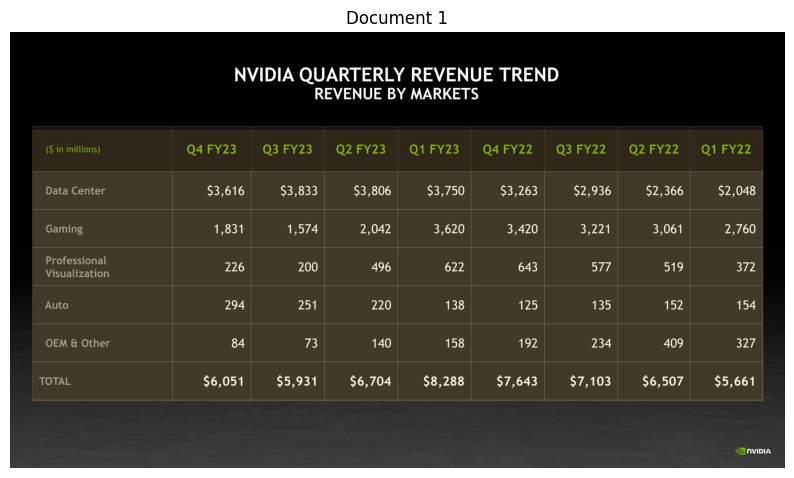


--- Processing Document 2 ---
Retrieval Info for Document 2:


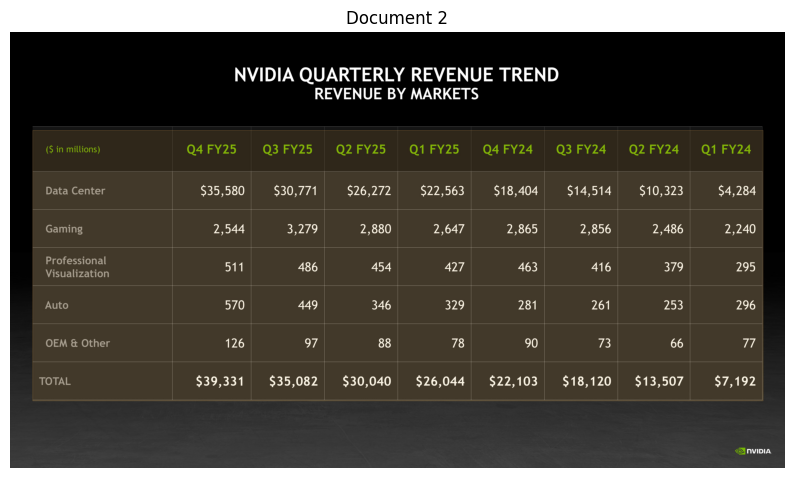


--- Processing Document 3 ---
Retrieval Info for Document 3:


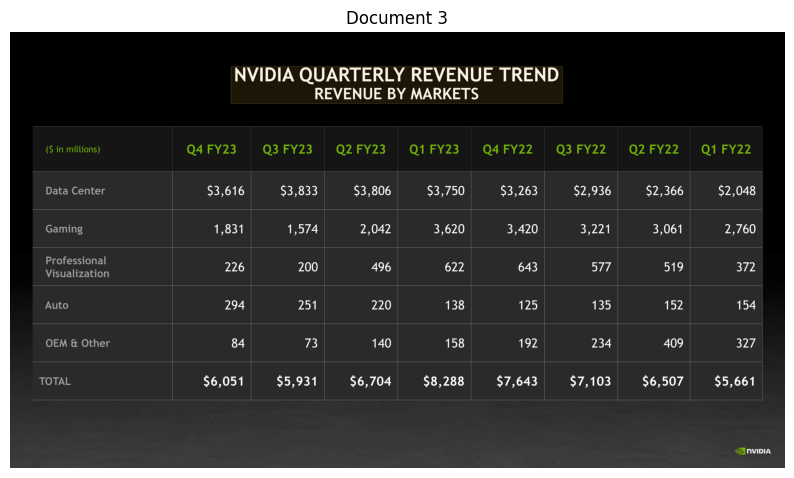


--- Processing Document 4 ---
Retrieval Info for Document 4:


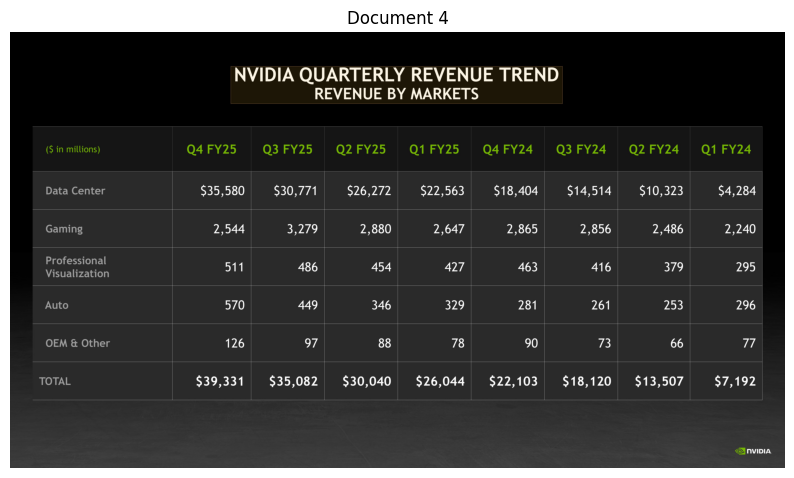


--- Processing Document 5 ---
Retrieval Info for Document 5:


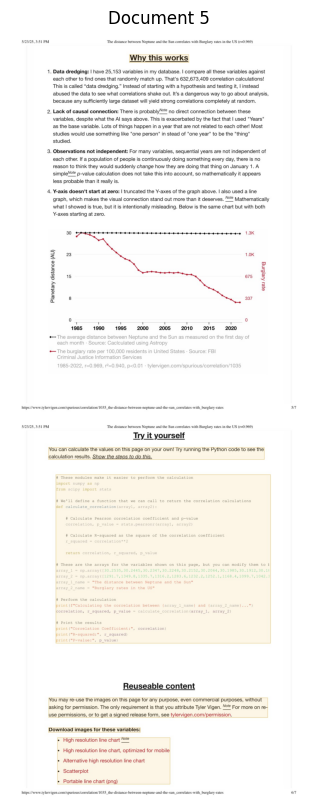


--- Processing Document 6 ---
Retrieval Info for Document 6:


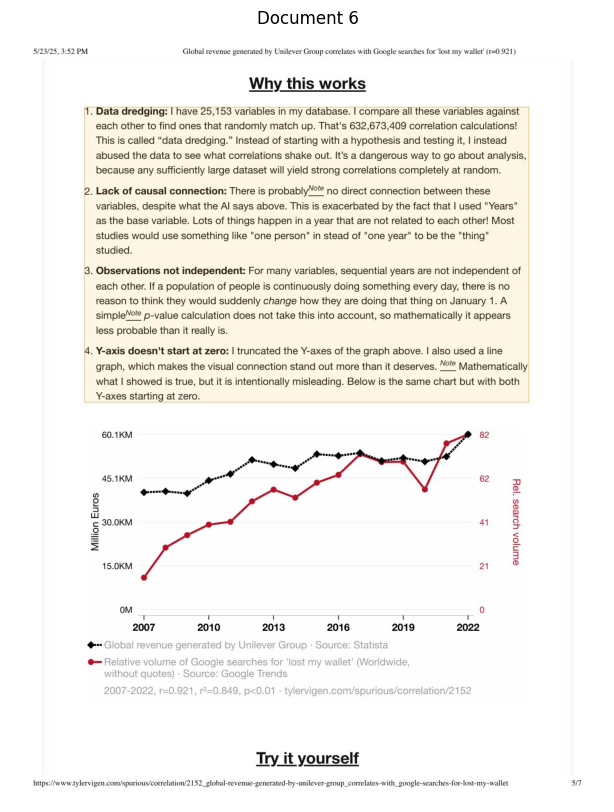


--- Processing Document 7 ---
Retrieval Info for Document 7:


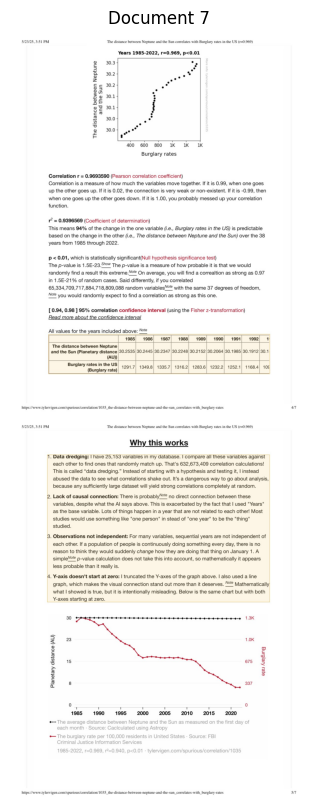


--- Processing Document 8 ---
Retrieval Info for Document 8:


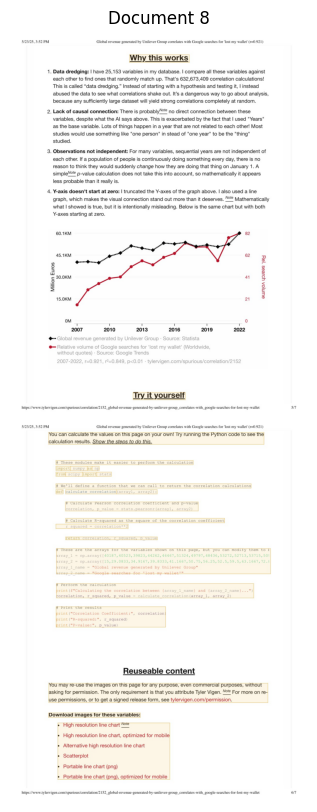


--- Processing Document 9 ---
Retrieval Info for Document 9:


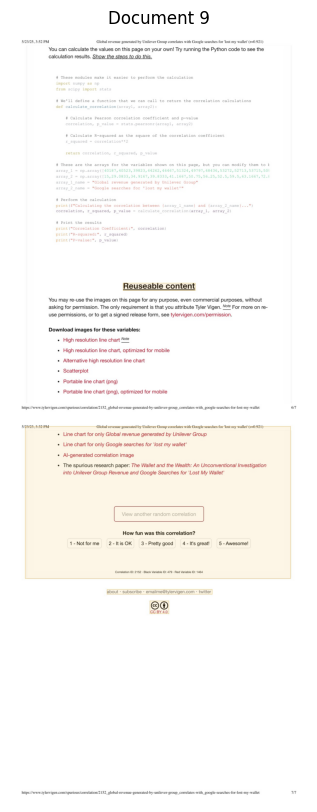


--- Processing Document 10 ---
Retrieval Info for Document 10:


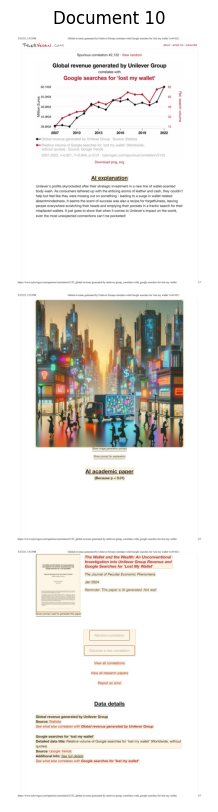


--- Processing Document 11 ---
Retrieval Info for Document 11:


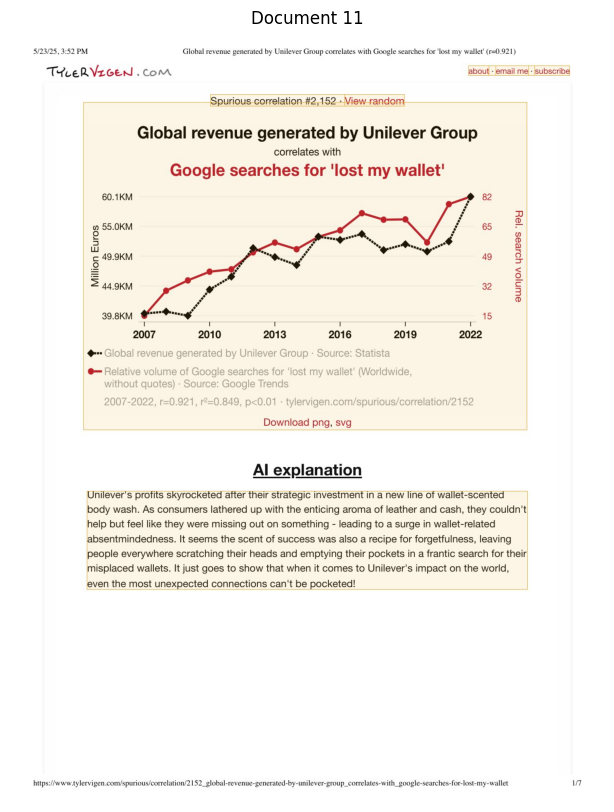


--- Processing Document 12 ---
Retrieval Info for Document 12:


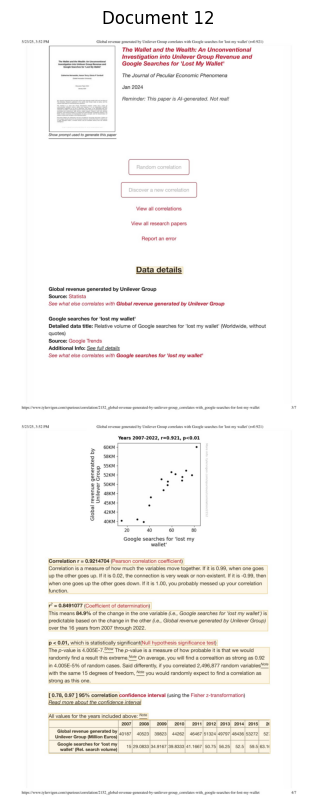


--- Processing Document 13 ---
Retrieval Info for Document 13:


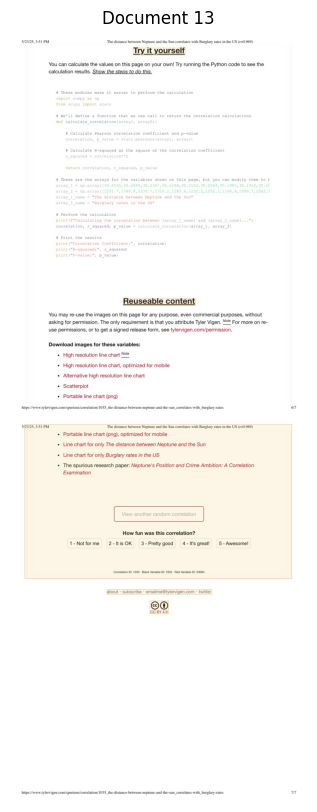


--- Processing Document 14 ---
Retrieval Info for Document 14:


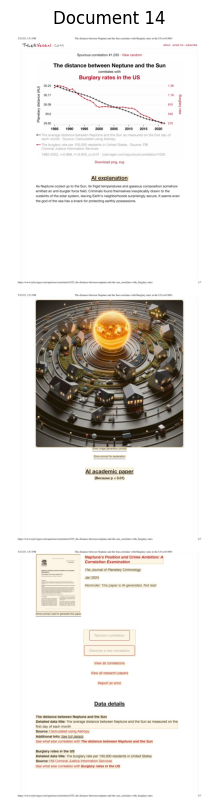


--- Processing Document 15 ---
Retrieval Info for Document 15:


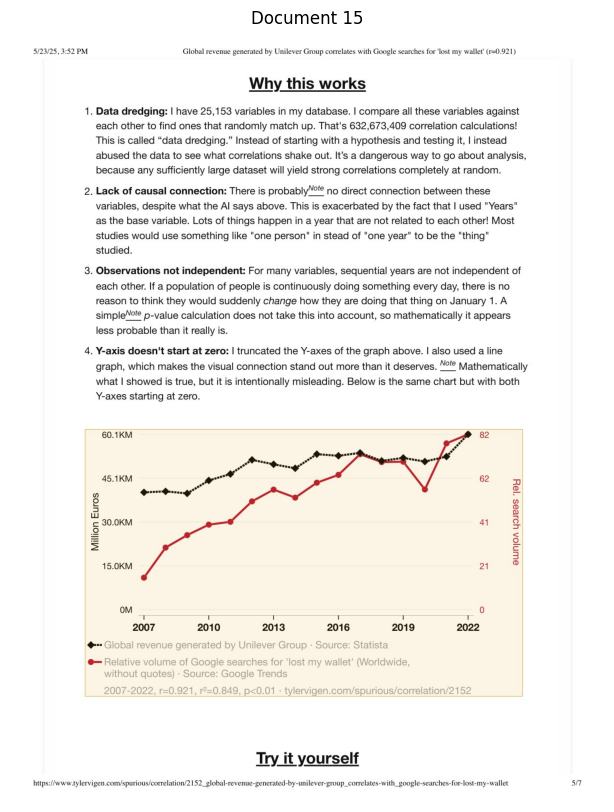


Total documents processed: 15


In [14]:
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt

def display_base64_image(base64_string, title="Document"):
    # Decode base64 string
    img_data = base64.b64decode(base64_string)

    # Create PIL Image object
    img = Image.open(io.BytesIO(img_data))

    # Display using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

    return img

# Retrieve and display all referenced documents
for i, retrieval_content in enumerate(query_result.retrieval_contents):
    print(f"\n--- Processing Document {i+1} ---")

    # Get retrieval info for this document
    ret_result = client.agents.query.retrieval_info(
        message_id=query_result.message_id,
        agent_id=agent_id,
        content_ids=[retrieval_content.content_id]
    )

    print(f"Retrieval Info for Document {i+1}:")

    # Display the document image
    if ret_result.content_metadatas and ret_result.content_metadatas[0].page_img:
        base64_string = ret_result.content_metadatas[0].page_img
        img = display_base64_image(base64_string, f"Document {i+1}")
    else:
        print(f"No image available for Document {i+1}")

print(f"\nTotal documents processed: {len(query_result.retrieval_contents)}")

## Paso 6. Evaluación del Agente.
```{index} LMUnit
```
** Comprender el marco de pruebas LMUnit**

Para garantizar que nuestro agente RAG funcione de forma fiable en producción, necesitamos una evaluación sistemática que vaya más allá de las pruebas manuales. Contextual AI ofrece LMUnit, un marco de pruebas de lenguaje natural que evalúa los sistemas RAG en múltiples dimensiones.

Para más detalles se puede consultar <a href="https://contextual.ai/research/lmunit?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook" target="_blank"> este blog </a>y también en <a href="https://github.com/ContextualAI/examples/blob/main/03-standalone-api/01-lmunit/lmunit.ipynb?utm_campaign=agents-towards-production&utm_source=diamantai&utm_medium=github&utm_content=notebook" target="_blank"> este notebook </a>.

### ¿Por qué es importante la evaluación automatizada?.

Las pruebas manuales por sí solas no son suficientes para los sistemas RAG de producción. Las pruebas unitarias de lenguaje natural le permiten:

* Desglosar la evaluación en criterios específicos y comprobables.
  
* Obtener información detallada sobre diversos aspectos de calidad.

* Impulsar mejoras sistemáticas en los resultados de LLM.

* Respaldar estándares de calidad específicos del dominio.

Para este ejemplo, utilizaremos pruebas unitarias globales que ejecutaremos en todas nuestras respuestas. Las siguientes fueron las seis dimensiones críticas para el razonamiento cuantitativo que elegimos como pruebas unitarias:

1. Precisión

Pregunta: «¿La respuesta extrae con precisión datos numéricos específicos de los documentos?».
Por qué: garantiza que las respuestas identifiquen y utilicen correctamente la información cuantitativa.

2. Causalidad

Pregunta: «¿El agente distingue adecuadamente entre correlación y causalidad?».
Por qué: comprueba si el razonamiento analítico es sólido y evita falacias lógicas.

3. Síntesis

Pregunta: «¿Se realizan correctamente las comparaciones entre varios documentos con cálculos precisos?».
Por qué: valida la capacidad de sintetizar información de distintas fuentes.

4. Limitaciones

Pregunta: «¿Se reconocen claramente las posibles limitaciones o incertidumbres de los datos?».
Por qué: garantiza las advertencias adecuadas y la transparencia.

5. Evidencia

Pregunta: «¿Las afirmaciones cuantitativas están debidamente respaldadas con evidencia específica de los documentos de origen?».
Por qué: comprueba si las conclusiones están debidamente fundamentadas en el material de origen.

6. Relevancia

Pregunta: «¿La respuesta evita información innecesaria?».
Por qué: verifica que las respuestas se mantengan centradas y concisas.

Estas son las pruebas unitarias que vamos a ejecutar para determinar el rendimiento de nuestro sistema:

In [15]:
unit_tests = [
      "Does the response accurately extract specific numerical data from the documents?",
      "Does the agent properly distinguish between correlation and causation?",
      "Are multi-document comparisons performed correctly with accurate calculations?",
      "Are potential limitations or uncertainties in the data clearly acknowledged?",
      "Are quantitative claims properly supported with specific evidence from the source documents?",
      "Does the response avoid unnecessary information?"
]

LMUnit está específicamente entrenado para evaluar pruebas unitarias en lenguaje natural y proporciona:

* Puntuaciones en una escala continua del 1 al 5.

* Evaluación coherente en diferentes criterios.

* Mejor rendimiento que los LLM de uso general.

* Capacidad para añadir rúbricas a la evaluación.

  
Comencemos con un ejemplo sencillo para comprender cómo funciona LMUnit:

In [16]:
response = client.lmunit.create(
                    query="What was NVIDIA's Data Center revenue in Q4 FY25?",
                   response = """NVIDIA's Data Center revenue for Q4 FY25 was $35,580 million.\[1\]()

                                This represents a significant increase from the previous quarter (Q3 FY25) when Data Center revenue was $30,771 million.[1]()

                                The full quarterly trend for Data Center revenue in FY25 was:
                                - Q4 FY25: $35,580 million
                                - Q3 FY25: $30,771 million
                                - Q2 FY25: $26,272 million
                                - Q1 FY25: $22,563 million[1]()
                              """,
                    unit_test="Does the response avoid unnecessary information?"
                )
print(response)

LMUnitCreateResponse(score=2.338)


¡La respuesta incluía información innecesaria! Más adelante podemos ajustar nuestra solicitud para que se adapte mejor a este requisito.

Comencemos por crear un conjunto de datos de evaluación con 6 consultas. Este conjunto de datos se genera preguntando a nuestro agente RAG las consultas enumeradas y guardando las respuestas generadas para su evaluación.

In [17]:
# RAG Evaluation Questions
queries = [
   "What was NVIDIA's Data Center revenue in Q4 FY25?",
   "What is the correlation coefficient between Neptune's distance from the Sun and US burglary rates?",
   "How did NVIDIA's total revenue change from Q1 FY22 to Q4 FY25?",
   "What are the four main reasons why spurious correlations work, according to the Tyler Vigen documents?",
   "Why should we be skeptical of the correlation between Unilever's revenue and Google searches for 'lost my wallet'?",
   "When did NVIDIA's data center revenue overtake gaming revenue?"
]

# Create DataFrame from questions
eval = pd.DataFrame({'prompt': queries})
eval['response'] = ''

# Query the agent for each question
for index, row in eval.iterrows():
   try:
       query_result = client.agents.query.create(
           agent_id=agent_id,
           messages=[{
               "content": row['prompt'],
               "role": "user"
           }]
       )
       eval.at[index, 'response'] = query_result.message.content
   except Exception as e:
       print(f"Error processing row {index}: {e}")
       eval.at[index, 'response'] = f"Error: {e}"

print(eval[['prompt', 'response']])
# prompt: save eval as csv

eval.to_csv('eval_input.csv', index=False)

                                              prompt  \
0  What was NVIDIA's Data Center revenue in Q4 FY25?   
1  What is the correlation coefficient between Ne...   
2  How did NVIDIA's total revenue change from Q1 ...   
3  What are the four main reasons why spurious co...   
4  Why should we be skeptical of the correlation ...   
5  When did NVIDIA's data center revenue overtake...   

                                            response  
0  NVIDIA's Data Center revenue for Q4 FY25 was $...  
1  The correlation coefficient (Pearson correlati...  
2  NVIDIA's total revenue in Q1 FY22 was $5,661 m...  
3  | Reason Number | Description | \n|-----------...  
4  The correlation between Unilever's global reve...  
5  NVIDIA's quarterly revenue data shows a clear ...  


Ahora probemos el lote completo:

In [18]:
def run_unit_tests_with_progress(
    df: pd.DataFrame,
    unit_tests: List[str],
    batch_size: int = 10
) -> List[Dict]:
    """
    Run unit tests with progress tracking and error handling.

    Args:
        df: DataFrame with prompt-response pairs
        unit_tests: List of unit test strings
        batch_size: Number of tests to run in parallel

    Returns:
        List of test results
    """
    results = []

    # Iterate over the DataFrame rows
    for idx in tqdm(range(0, len(df)), desc="Processing responses"):
        row = df.iloc[idx]
        row_results = []

        # Run each unit test on the current prompt-response pair
        for test in unit_tests:
            try:
                result = client.lmunit.create(
                    query=row['prompt'],
                    response=row['response'],
                    unit_test=test
                )

                # Collect the test result score and metadata if available
                row_results.append({
                    'test': test,
                    'score': result.score,
                    'metadata': result.metadata if hasattr(result, 'metadata') else None
                })

            except Exception as e:
                print(f"Error with prompt {idx}, test '{test}': {e}")
                row_results.append({
                    'test': test,
                    'score': None,
                    'error': str(e)
                })

        # Store results
        results.append({
            'prompt': row['prompt'],
            'response': row['response'],
            'test_results': row_results
        })

    return results

from tqdm import tqdm
results = run_unit_tests_with_progress(eval, unit_tests)

pd.DataFrame([(r['prompt'], r['response'], t['test'], t['score']) for r in results for t in r['test_results']], columns=['prompt', 'response', 'test', 'score']).to_csv(f"unit_test_results.csv", index=False)
df = pd.read_csv("unit_test_results.csv")

for result in results[:2]:  # Slice to get the first two entries
    print(f"\nPrompt: {result['prompt']}")
    print(f"Response: {result['response']}")
    print("Test Results:")
    for test_result in result['test_results']:
        print(f"- {test_result['test']}: {test_result['score']}")

Processing responses: 100%|██████████████████████████████████████████████████████████████| 6/6 [01:20<00:00, 13.44s/it]


Prompt: What was NVIDIA's Data Center revenue in Q4 FY25?
Response: NVIDIA's Data Center revenue for Q4 FY25 was $35,580 million.[1]()

| Period | Data Center Revenue (millions) |
|--------|-------------------------------|
| Q4 FY25 | $35,580 |
| Q3 FY25 | $30,771 |
| Q2 FY25 | $26,272 |
| Q1 FY25 | $22,563 |
| Q4 FY24 | $18,404 |[1]()
Test Results:
- Does the response accurately extract specific numerical data from the documents?: 2.757
- Does the agent properly distinguish between correlation and causation?: 1.611
- Are multi-document comparisons performed correctly with accurate calculations?: 3.211
- Are potential limitations or uncertainties in the data clearly acknowledged?: 1.363
- Are quantitative claims properly supported with specific evidence from the source documents?: 3.052
- Does the response avoid unnecessary information?: 2.031

Prompt: What is the correlation coefficient between Neptune's distance from the Sun and US burglary rates?
Response: The correlation coefficie

Ahora podemos visualizar las métricas con gráficos polares. Los gráficos polares (también llamados gráficos de radar o gráficos de araña) son especialmente útiles para visualizar puntuaciones multidimensionales, ya que destacan por mostrar patrones y compensaciones entre varias métricas relacionadas simultáneamente.

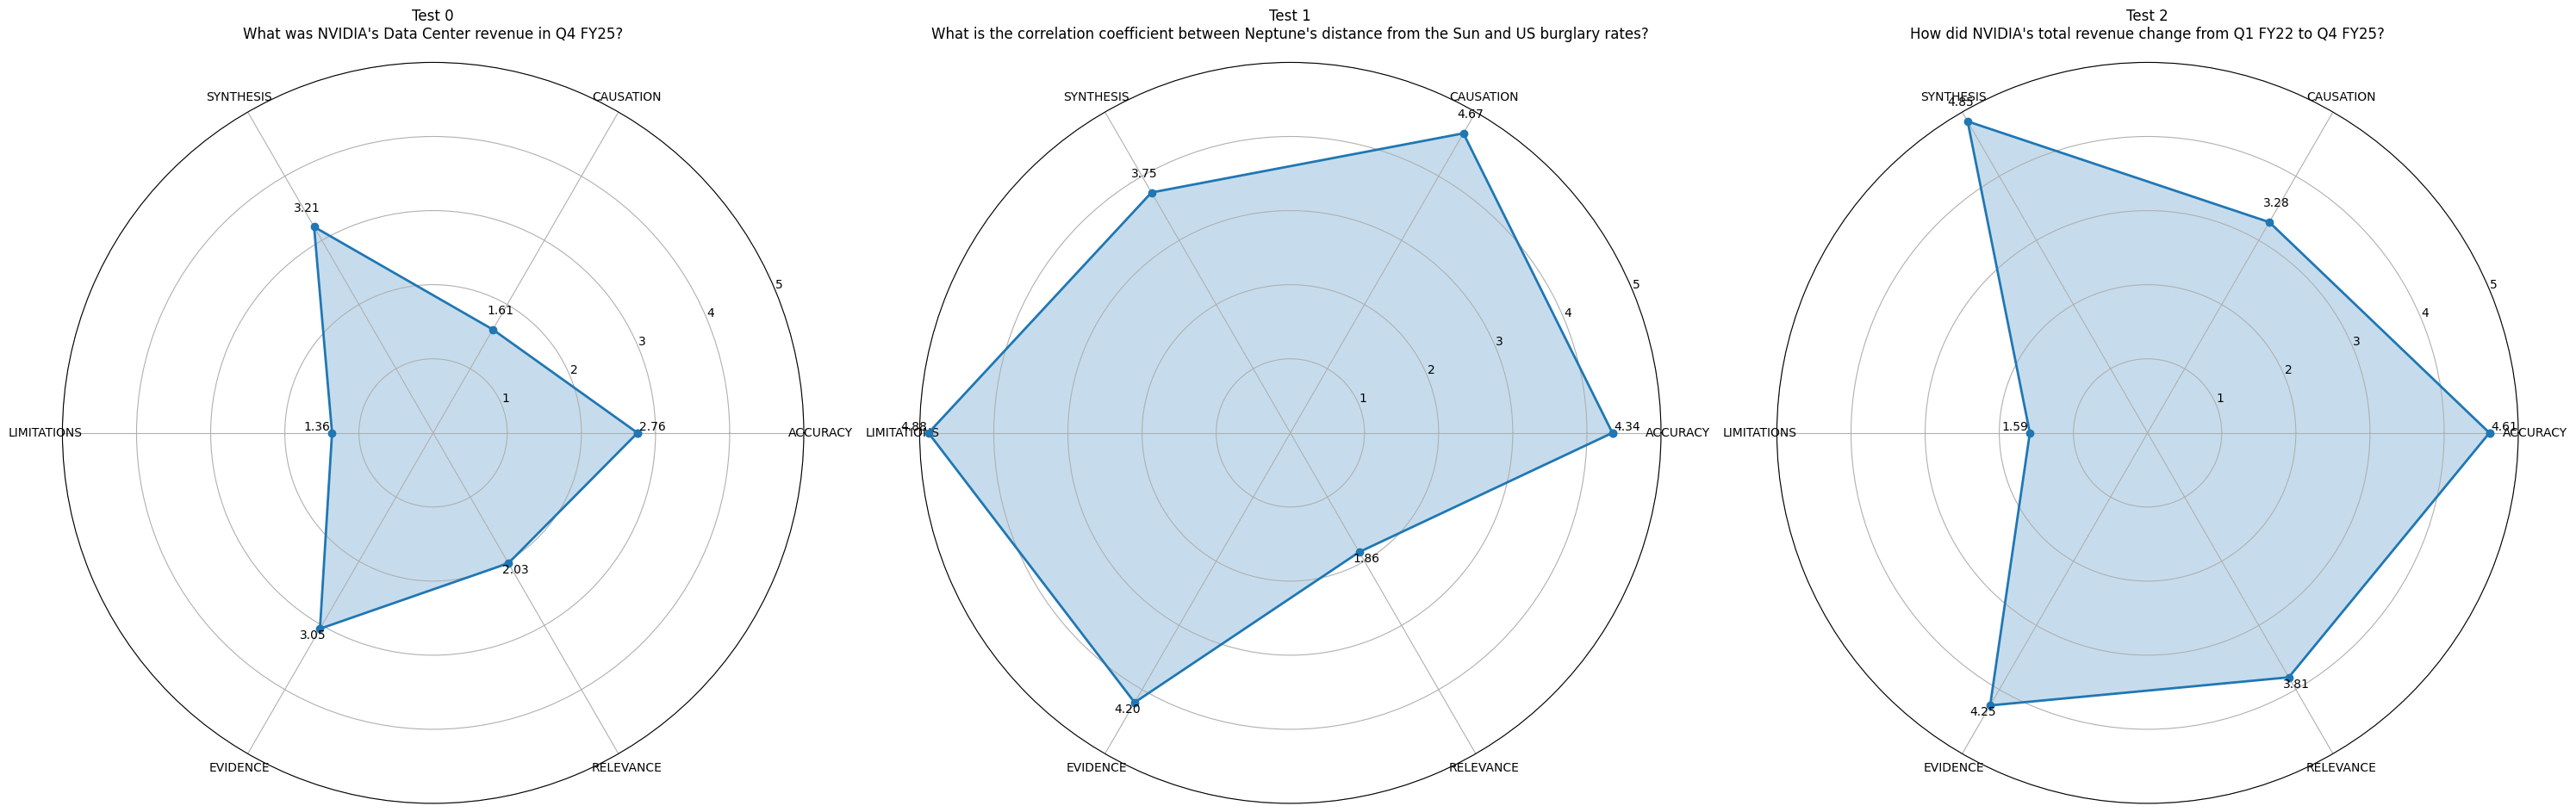

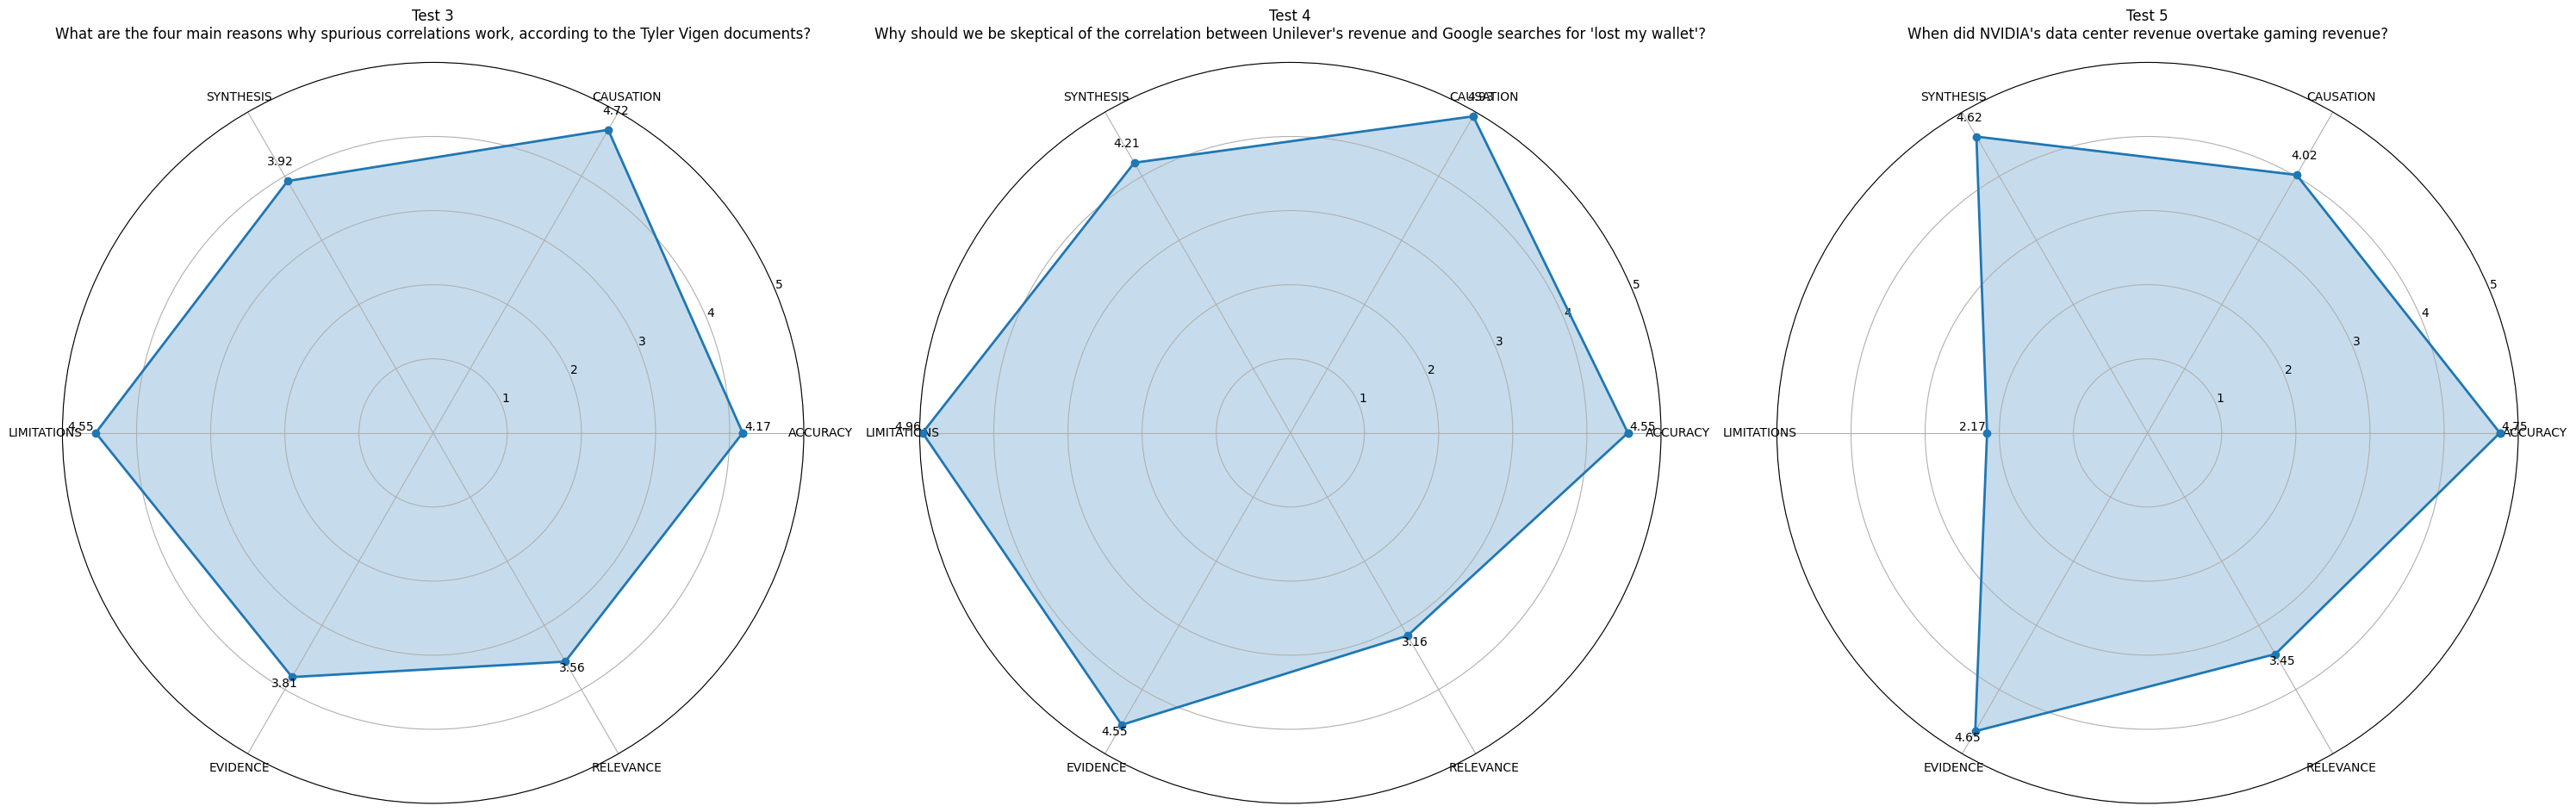

In [19]:
# For polar plots
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Tuple

#clustering analysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

def map_test_to_category(test_question: str) -> str:
    """Map the full test question to its category."""
    category_mapping = {
        'Does the response accurately extract specific numerical data': 'ACCURACY',
        'Does the agent properly distinguish between correlation and causation': 'CAUSATION',
        'Are multi-document comparisons performed correctly': 'SYNTHESIS',
        'Are potential limitations or uncertainties in the data': 'LIMITATIONS',
        'Are quantitative claims properly supported with specific evidence': 'EVIDENCE',
        'Does the response avoid unnecessary information': 'RELEVANCE'
    }

    for key, value in category_mapping.items():
        if key.lower() in test_question.lower():
            return value
    return None

def create_unit_test_plots(results: List[Dict],
                          test_indices: Optional[Union[int, List[int]]] = None,
                          figsize: tuple = (10, 10)):
    """
    Create polar plot(s) for unit test results. Can plot either a single test,
    specific multiple tests, or all tests in a row.

    Args:
        results: List of dictionaries containing test results
        test_indices: Optional; Either:
            - None (plots all results)
            - int (plots single result)
            - List[int] (plots multiple specific results)
        figsize: Tuple specifying the figure size (width, height)
    """
    # Handle different input cases for test_indices
    if test_indices is None:
        indices_to_plot = list(range(len(results)))
    elif isinstance(test_indices, int):
        if test_indices >= len(results):
            raise IndexError(f"test_index {test_indices} is out of range. Only {len(results)} results available.")
        indices_to_plot = [test_indices]
    else:
        if not test_indices:
            raise ValueError("test_indices list cannot be empty")
        if max(test_indices) >= len(results):
            raise IndexError(f"test_index {max(test_indices)} is out of range. Only {len(results)} results available.")
        indices_to_plot = test_indices

    # Categories in desired order
    categories = ['ACCURACY', 'CAUSATION', 'SYNTHESIS',
                'LIMITATIONS', 'EVIDENCE', 'RELEVANCE']

    # Set up the angles for the polar plot
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Close the plot

    # Calculate figure size based on number of plots
    num_plots = len(indices_to_plot)
    fig_width = figsize[0] * num_plots
    fig = plt.figure(figsize=(fig_width, figsize[1]))

    # Create a subplot for each result
    for plot_idx, result_idx in enumerate(indices_to_plot):
        result = results[result_idx]

        # Create subplot
        ax = plt.subplot(1, num_plots, plot_idx + 1, projection='polar')

        # Get scores for this result
        scores = []
        for category in categories:
            score = None
            for test_result in result['test_results']:
                mapped_category = map_test_to_category(test_result['test'])
                if mapped_category == category:
                    score = test_result['score']
                    break
            scores.append(score if score is not None else 0)

        # Close the scores array
        scores = np.concatenate((scores, [scores[0]]))

        # Plot the scores
        ax.plot(angles, scores, 'o-', linewidth=2)
        ax.fill(angles, scores, alpha=0.25)

        # Set the labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)

        # Set the scale
        ax.set_ylim(0, 5)

        # Add grid
        ax.grid(True)

        # Add score values as annotations
        for angle, score, category in zip(angles[:-1], scores[:-1], categories):
            ax.text(angle, score + 0.2, f'{score:.2f}',
                    ha='center', va='bottom')

        # Add title for each subplot
        prompt = result['prompt']
        ax.set_title(f"Test {result_idx}\n{prompt}", pad=20)

    plt.tight_layout()
    return fig

# Plot the test results
fig = create_unit_test_plots(results, test_indices=[0, 1, 2])
fig = create_unit_test_plots(results, test_indices=[3, 4, 5])

**NOTA FINAL**: Como ya se ha dicho, la utilización de esta herramienta tiene un coste (hay un crédito gratuito para iniciarse), y para la realización de este ejemplo, el coste asociado al mismo **ha sido de 1 dolar** (que no se ha pagado pues se ha utilizado el crédito gratuito asociado al alta en la plataforma, aunque se ha constatdo que el mayor coste ha sido el subir los documentos y la ingestión de los mismos, el cual ha sido de 0,7 dólares).

## Apéndice.

Otros muchos más agentes o desarrollos IA <a href="https://github.com/NirDiamant/agents-towards-production" target="_blank"> se puede encontrar en este enlace </a>.